# RAND-FGSM | EPOCH Lab: Ricoh

In [1]:
%pylab inline

from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms

Populating the interactive namespace from numpy and matplotlib


In [2]:
print("CUDA Available: ", torch.cuda.is_available())
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")

CUDA Available:  False


In [3]:
model = models.inception_v3(pretrained=True).to(device)
model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [4]:
!curl https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt --output data/imagenet_classes.txt
    
with open("data/imagenet_classes.txt", "r") as f:
    classes = [s.strip() for s in f.readlines()]

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 10472  100 10472    0     0  41541      0 --:--:-- --:--:-- --:--:-- 42225


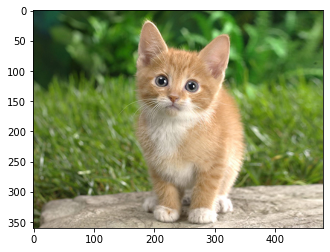

In [5]:
img = Image.open("/Volumes/artemis/library/datasets/cat.jpg")
plt.imshow(img)

In [6]:
preprocess = transforms.Compose([transforms.Resize(256),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                ])

In [7]:
input_tensor = preprocess(img).unsqueeze(0)

In [8]:
def predict(img):
    output = model(img)
    pred = F.softmax(output, dim=1)
    _, indicies = torch.topk(pred, k=1)
    for i in indicies.data.numpy().ravel():
        cost = pred.data[0][i]
        print("Class ID: {} | Label: {} | Accuracy: {}%".format(str(i), classes[i], 100 * cost))

In [9]:
predict(input_tensor)

Class ID: 282 | Label: tiger cat | Accuracy: 93.17092895507812%


### False Memory

In [10]:
def rand_fgsm_attack(image, epsilon, gradient, alpha):
    rand_image = image + alpha * torch.rand(image.shape).sign()
    epsilon -= alpha
    
    preturbed_image = rand_image + epsilon * gradient.sign()
    return preturbed_image

In [11]:
image = input_tensor.clone()
target = torch.tensor(282).unsqueeze(0)    #Tiger cat

In [12]:
epsilon = [0, .05, .1, .15, .2, .25, .3]

examples = []

for e in epsilon:
    image, target = image.to(device), target.to(device)

    image.requires_grad = True
    
    output = model(image)
    init_pred = output.max(1, keepdim=True)[1]
    
    loss = nn.CrossEntropyLoss()(output, target).to(device)
    
    model.zero_grad()
    loss.backward()
    
    gradient = image.grad.data
    
    perturb_data = rand_fgsm_attack(image, e, gradient, 0.05)
    predict(perturb_data)
    
    output = model(perturb_data)
    final_pred = output.max(1, keepdim=True)[1]
    
    examples.append((init_pred, final_pred, perturb_data))

Class ID: 282 | Label: tiger cat | Accuracy: 99.96973419189453%
Class ID: 282 | Label: tiger cat | Accuracy: 93.16094970703125%
Class ID: 151 | Label: Chihuahua | Accuracy: 36.294857025146484%
Class ID: 151 | Label: Chihuahua | Accuracy: 20.915189743041992%
Class ID: 151 | Label: Chihuahua | Accuracy: 12.359428405761719%
Class ID: 333 | Label: hamster | Accuracy: 9.36935806274414%
Class ID: 333 | Label: hamster | Accuracy: 6.937174320220947%


In [13]:
denorm = transforms.Compose([transforms.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
                             transforms.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1])])

In [14]:
def postprocess(data):
    image = denorm(data.squeeze()).detach().numpy()
    image = np.rollaxis(image, 0, 3)
    return image

In [15]:
i = 6

attack_image = postprocess(examples[i][2])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tiger cat > hamster


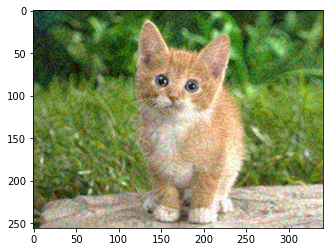

In [16]:
plt.imshow(attack_image)
print(classes[examples[i][0]], ">", classes[examples[i][1]])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


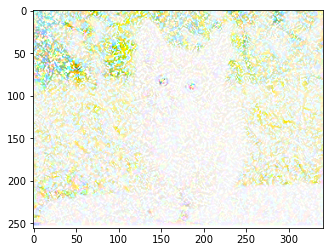

In [17]:
diff = (attack_image / postprocess(input_tensor))
plt.imshow(diff)